<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/Train_Anger_RNN_attent_May5%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anger Training run - Last updated May 5,2023

Synchronize this notebook with the new dataset creation capacity. We also want to try to synchronize the word distribution as well... 



In [1]:
#Need pip install tensorflow with...Jupyter Notebook

!pip install nlp
#!pip install tensorflow
!pip install h5py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle

In [3]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Setting column options

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)

#Supressing the scientific notation 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Import the Tokenizer

In [5]:
path = '/content/drive/MyDrive/Sean/Emoclass/Tokenizer_Universal_125Kvoc_May5.2023.pickle'

with open(path, 'rb') as f:
    tokenizer = pickle.load(f)

#Importing inference dataset

In [6]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load inference dataset...Let's use df1 so there are no mix ups 

df1 = pd.read_csv("/content/drive/MyDrive/Sean/Twitter/COVID_223KTweets.csv")

In [8]:
df1.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [9]:
#Create word length function... 

def count_words(text):
    return len(text.split())

In [10]:
#Applying the function... 

df1['word_count'] = df1['tweet'].apply(count_words)

##Importing dataset and defining emotion axis 

In [11]:
#Anger Schema - May 4,2023  
#If we call it emo_axis -> we don't have to change it across capabilities....

emo_axis = {
    "rage": ['rage', 'raging', 'raged', 'fury', 'wrath', 'wrathful', 'furious', 'enraged', 'enraging', 'incensed', 'outraged'],
    "angry": ["angry", "anger", "angered", "mad", "maddening", "maddened"],
    "frustrated": ["frustration", "frustrate", "frustrated", "frustrating", "exasperated", "exasperating", "discontented", "vexed", "vexing", "bothered", "bothersome"],
    "agitated": ["agitated", "agitating", "agitation", "aggravated", "aggravation", "aggravating", "upset", 'upsetting', 'irritate', 'irritating', 'irritable', 'irritated'],
    "annoyed": ["annoying", "annoy", "annoyed", "pestered", "pestering", "pester", "troubled", "troubling", "disturbed", "disturbing", "harassed", "harassing", "nagged", "nagging"],
    "calm": ["calm", "peaceful", "serene", "serenity", "relax", "relaxing", "relaxed"]
}


In [12]:
#Load the dataset 

path = "/content/drive/MyDrive/Sean/Emoclass/Emotion datasets/Anger_G2000_1million_May3,2023.csv"
df=pd.read_csv(path)

In [13]:
df.shape

(999996, 6)

In [14]:
#Looking at the dataset 

#df.head(100)

In [15]:
df.columns

Index(['text', 'emotion1', 'emotion2', 'num_words', 'treatment', 'new_word_length'], dtype='object')

In [16]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [17]:
#Checking to see if classes are balanced or not...

df['label'].value_counts()

angry         284504
rage          242074
calm          149943
annoyed       147975
agitated      104374
frustrated     71126
Name: label, dtype: int64

#Optional: Truncating Word Length 

In [18]:
#Apply function to calculate word length

df['word_count'] = df['text'].apply(count_words)

In [19]:
df['word_count'].describe()

count   999996.000
mean        50.220
std         21.485
min          5.000
25%         34.000
50%         44.000
75%         72.000
max        100.000
Name: word_count, dtype: float64

##Redoing Truncation with ChatGPT Quantiles derived from inference dataset 

In [22]:
# Creating a quantile list
quantile_list = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

# Calculate quantiles for both datasets using the quantile list
quantiles_df = pd.DataFrame({
    'Inference_dataset': df1['word_count'].quantile(quantile_list),
    'Training_dataset': df['word_count'].quantile(quantile_list)
})

# Calculate the difference between quantile values for each dataset
quantiles_df['Difference'] = quantiles_df['Training_dataset'] - quantiles_df['Inference_dataset']

# Define a function to get the quantile difference for a given word_count value
def get_quantile_diff(word_count, quantiles_df):
    for i in range(len(quantile_list) - 1):
        if word_count <= quantiles_df.loc[quantile_list[i+1], 'Training_dataset']:
            return quantiles_df.loc[quantile_list[i], 'Difference']
    return quantiles_df.loc[quantile_list[-1], 'Difference']

# Calculate 'quantile_diff' for each row in the 'df' DataFrame
df['quantile_diff'] = df['word_count'].apply(lambda x: get_quantile_diff(x, quantiles_df))

# Display the resulting dataframe
df.head()


,text,emotion1,label,num_words,treatment,new_word_length,word_count,quantile_diff
0,class it must be admitted that holding one s s...,angry,angry,74,Nothing,74,74,36.000
1,tailor he dropped the garments at the feet of ...,furious,rage,73,Nothing,73,73,36.000
2,all the men of riches have found nothing in th...,wrath,rage,77,Nothing,77,77,36.000
3,him to the blow no crimson torrent issued at t...,anger,angry,73,Nothing,73,73,36.000
4,sudden determinations which make fools say of ...,relaxed,calm,72,Nothing,72,72,20.000


In [23]:
#Defining a function to remove text from both ends based on difference in values in quantiles...

def truncate_text(text, quantile_diff):
    words = text.split()
    words_to_remove = int(abs(quantile_diff))
    
    if words_to_remove >= len(words):
        return ""
    
    if quantile_diff > 0:
        # Remove words equally from the beginning and the end
        start_index = words_to_remove // 2
        end_index = -(words_to_remove - start_index)
        if end_index == 0:
            truncated_words = words[start_index:]
        else:
            truncated_words = words[start_index:end_index]
    else:
        # Add placeholder words to the beginning and the end
        placeholder = "<placeholder>"
        padding = [placeholder] * (words_to_remove // 2)
        truncated_words = padding + words + padding
    
    truncated_text = ' '.join(truncated_words)
    return truncated_text



In [24]:
# Truncate the text in the 'text' column based on the 'quantile_diff' values
df['truncated_text'] = df.apply(lambda row: truncate_text(row['text'], row['quantile_diff']), axis=1)

# Display the resulting dataframe
df.head()

,text,emotion1,label,num_words,treatment,new_word_length,word_count,quantile_diff,truncated_text
0,class it must be admitted that holding one s s...,angry,angry,74,Nothing,74,74,36.000,to seem to winterbourne more and more a matter...
1,tailor he dropped the garments at the feet of ...,furious,rage,73,Nothing,73,73,36.000,so recently been lying flung out the transluce...
2,all the men of riches have found nothing in th...,wrath,rage,77,Nothing,77,77,36.000,they have all slumbered that mounted on horseb...
3,him to the blow no crimson torrent issued at t...,anger,angry,73,Nothing,73,73,36.000,stream ebbed slowly downward aruns at the sigh...
4,sudden determinations which make fools say of ...,relaxed,calm,72,Nothing,72,72,20.000,is the contempt which the world pours out on p...


In [25]:
#Reapply word count

df['trunc_word_counts'] = df['truncated_text'].apply(count_words)

In [26]:
df['trunc_word_counts'].describe()

count   999996.000
mean        28.282
std         14.856
min          1.000
25%         15.000
50%         23.000
75%         42.000
max         65.000
Name: trunc_word_counts, dtype: float64

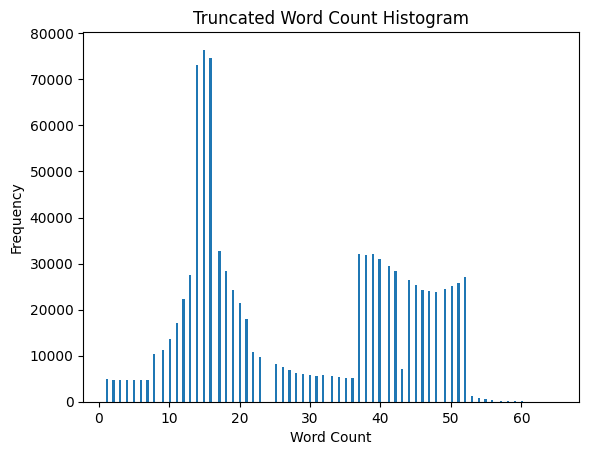

In [27]:
import matplotlib.pyplot as plt

plt.hist(df['trunc_word_counts'], bins=200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Truncated Word Count Histogram')
plt.show()


# ***Reassigning Truncated Text Variable Back 

In [28]:
df['text'] = df['truncated_text']

##Replacing the emotion words in the dataset 

In [29]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 
keyword = "emotions"
words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,keyword)

##Counting vocab size 

In [30]:
from collections import Counter

# Define a function to split text into words
def split_text(text):
    return text.split()

# Split the text in the 'text' column and count the occurrences of each word
word_counter = Counter()
for text in df['text']:
    words = split_text(text)
    word_counter.update(words)

# Calculate the vocabulary size
vocab_size = len(word_counter)

print(f"The vocabulary size is: {vocab_size}")


The vocabulary size is: 76690


##Splitting into train, validate and test datasets inluding shuffle dataset 

In [31]:
#This outputs 3 different dataframes... originally 0.6 and 0.8

train, validate, test = np.split(df.sample(frac=1, random_state=42),
                       [int(.8*len(df)), int(.9*len(df))])

##Preparing Labels - Need to change emotion axis 

In [32]:
#Converting the pandas dataframe into a list of labels... 
#We may consider puting this into a function... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

In [33]:
#Creating the classes variable... with new emotion classifier..
# loneliness_axis

classes = list(emo_axis.keys())


In [34]:
# Map each class to a unique integer
classes_to_index = dict((c, i) for i, c in enumerate(classes))

# Map each integer back to its corresponding class
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [35]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [36]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

5


In [37]:
#What is train_labels?

train_labels?

In [38]:
import numpy as np

# Use numpy's unique() and return_counts=True parameters to get value counts
values, counts = np.unique(train_labels, return_counts=True)

# Create a dictionary with the values and their respective counts
value_counts = dict(zip(values, counts))

# Print the dictionary
print(value_counts)


{0: 193634, 1: 227680, 2: 57030, 3: 83565, 4: 118291, 5: 119796}


##Input Training Text and Tokenizing Tweets

In [39]:
#Converting the different pandas dataframes into a list of text fields...
#Choice of variables: truncated_text, text_minus1, 'filtered_text',''filtered_text_minus1'

traintext=train['text'].tolist()
valtext=validate['text'].tolist()
testtext=test['text'].tolist()

In [40]:
#Importing the tokenizer...
#Input into the tokenizer is a list

#from tensorflow.keras.preprocessing.text import Tokenizer

In [41]:
#Input into the tokenizer is a list

#tokenizer = Tokenizer(num_words=131000, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

#tokenizer.fit_on_texts(traintext)
#tokenizer.fit_on_texts(valtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

#Padding and Truncating Sequences 

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
#Creating a function that tokenizes and pads the sequences...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=300, padding='post')
    return padded_sequences

In [44]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

padded_train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


#Adding attention layer and specifying the model 

In [45]:
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(131000, 150, input_length=300),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    Attention(),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          19650000  
                                                                 
 conv1d (Conv1D)             (None, 296, 200)          150200    
                                                                 
 bidirectional (Bidirectiona  (None, 296, 300)         421200    
 l)                                                              
                                                                 
 attention (Attention)       (None, 300)               596       
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
Total params: 20,223,802
Trainable params: 20,223,802
Non-trainable params: 0
____________________________________________

##Running the model


In [ ]:
#Most up to date architecture: April 15, 2023 -> Fa

#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/3
 8216/25000 [========>.....................] - ETA: 8:36 - loss: 1.1845 - accuracy: 0.5482

#Evaluating The Model 

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

In [ ]:
#preds = model.predict_classes(test_sequence)
preds=model.predict(test_sequence) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

##Error Analysis 

In [ ]:
#Dumb luck metric 

counts = df['label'].value_counts()
dumb_luck = max(counts) / sum(counts)

dumb_luck


In [ ]:
#Creating an inference dataframe 

inf_df=pd.DataFrame({
    'data':testtext,
    "labels_predicted": classes_x                    
})
inf_df["labels_predicted_marked"]=inf_df['labels_predicted'].apply(lambda x: index_to_classes[x])
inf_df["actual_labels"]=testlabel

#Creating the labels index datastructure...

inf_df["actual_label_index"]=inf_df['actual_labels'].apply(lambda x: classes_to_index[x])



In [ ]:
#Checking the inf_df shape...

inf_df.shape

In [ ]:
#Making the correct prediction 

inf_df['correct_pred']=0 # first assigning all to 0.
inf_df.loc[(inf_df['labels_predicted']==inf_df['actual_label_index']),'correct_pred']=1 # labelling 1 if the prediction is right.

In [ ]:
# magnitutde of error
inf_df['error_magnitude']=abs(inf_df['labels_predicted']-inf_df['actual_label_index'])

In [ ]:
# Count the frequency of each class in the error_magnitude column
counts = inf_df['error_magnitude'].value_counts()

# Create a histogram with one bar for each class
plt.bar(counts.index, counts.values)

# Set the title and axis labels
plt.suptitle('Histogram of Error Magnitude in Fear Classification')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

##Saving the model, tokenizer and evaluation datasets 

In [ ]:
from keras.models import load_model

# Make sure you provide the full file path, including the .h5 extension
#model.save('/content/drive/MyDrive/Sean/Emoclass_Dec2022/Model_Anger_1million_May4,2023.h5')


In [ ]:
#Saving the model 



In [ ]:
#Exporting the dataset 

#path = "/content/drive/MyDrive/Sean/Emoclass/Train_Fear_Error_Analysis_151K_March8,2023.csv"
inf_df.to_csv(path)
